# Customer Churn Prediction
<i>Last Update: 08/02/2020</i><br>
<i>PyCaret Version: 2.0</i><br>
<i>Author: Alexandre Farias</i><br>
<i>Email: afarias@tuta.io</i>

![](https://res.cloudinary.com/dn1j6dpd7/image/fetch/f_auto,q_auto,w_736/https://www.livechat.com/wp-content/uploads/2016/04/customer-churn@2x.jpg)
<i>Image Source:</i> [What Is Churn Rate and Why It Will Mess With Your Growth](https://www.livechat.com/success/churn-rate/)

# 1. Introduction
Customer Churn is when customers leave a service in a given period of time, which is bad for business.<br>
This work has as objective to build a machine learning model to predict which customers will leave the service, the dataset used on this notebook is the [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn) hosted at Kaggle. Also, an Exploratory Data Analysis is made to a better understand about the data. 
Another point on this work is use Deepnote as development enviroment and the [PyCaret 2.0](https://pycaret.org/) Python Module to make all the experiment pipeline. 

# 1.1 Enviroment Setup
The Modules used for this work, highlights for PyCaret 2.0 and good plots by [Plotly](https://plotly.com/).

In [1]:
# Standard
import pandas as pd
import numpy as np
import os
# Pycaret
from pycaret.classification import *
# Plots
from plotly.offline import iplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
# Sklearn tools
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
# Extras
from datetime import date
import warnings
warnings.filterwarnings("ignore")
# Datapath and Setup
os.chdir("..")
PATH = os.getcwd()+os.sep
RANDOM_SEED = 142
K_FOLDS = 5

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Himanshu Chehal\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1


And the helper functions used on this notebook.

In [3]:
# Helper functions for structured data
# Get info about the dataset
def dataset_info(dataset, dataset_name: str):
    print(f"Dataset Name: {dataset_name} \
        | Number of Samples: {dataset.shape[0]} \
        | Number of Columns: {dataset.shape[1]}")
    print(30*"=")
    print("Column             Data Type")
    print(dataset.dtypes)
    print(30*"=")
    missing_data = dataset.isnull().sum()
    if sum(missing_data) > 0:
        print(missing_data[missing_data.values > 0])
    else:
        print("No Missing Data on this Dataset!")
    print(30*"=")
    print("Memory Usage: {} MB".\
         format(np.round(
         dataset.memory_usage(index=True).sum() / 10e5, 3
         )))
# Dataset Sampling
def data_sampling(dataset, frac: float, random_seed: int):
    data_sampled_a = dataset.sample(frac=frac, random_state=random_seed)
    data_sampled_b =  dataset.drop(data_sampled_a.index).reset_index(drop=True)
    data_sampled_a.reset_index(drop=True, inplace=True)
    return data_sampled_a, data_sampled_b   
# Bar Plot
def bar_plot(data, plot_title: str, x_axis: str, y_axis: str):
    colors = ["#0080ff",] * len(data)
    colors[0] = "#ff8000"
    trace = go.Bar(y=data.values, x=data.index, text=data.values, 
                    marker_color=colors)
    layout = go.Layout(autosize=False, height=600,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"},  
                    xaxis={"title" : x_axis},
                    yaxis={"title" : y_axis},)
    fig = go.Figure(data=trace, layout=layout)
    fig.update_layout(template="simple_white")
    fig.update_traces(textposition="outside",
                    textfont_size=14,
                    marker=dict(line=dict(color="#000000", width=2)))                
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Plot Pie Chart
def pie_plot(data, plot_title: str):
    trace = go.Pie(labels=data.index, values=data.values)
    layout = go.Layout(autosize=False,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"})
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(textfont_size=14,
                    marker=dict(line=dict(color="#000000", width=2)))
    fig.update_yaxes(automargin=True)            
    iplot(fig)
# Histogram
def histogram_plot(data, plot_title: str, y_axis: str):
    trace = go.Histogram(x=data)
    layout = go.Layout(autosize=False,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"},  
                    yaxis={"title" : y_axis})
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(marker=dict(line=dict(color="#000000", width=2)))
    fig.update_layout(template="simple_white")
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Particular case: Histogram subplot (1, 2)
def histogram_subplot(dataset_a, dataset_b, feature_a: str,
                        feature_b: str, title: str, title_a: str, title_b: str):
    fig = make_subplots(rows=1, cols=2, subplot_titles=(
                        title_a,
                        title_b
                        )
                    )
    fig.add_trace(go.Histogram(x=dataset_a[feature_a],
                               showlegend=False),
                                row=1, col=1)
    fig.add_trace(go.Histogram(x=dataset_b[feature_b],
                               showlegend=False),
                              row=1, col=2)
    fig.update_layout(template="simple_white")
    fig.update_layout(autosize=False,
                        title={"text" : title,
                        "y" : 0.9,
                        "x" : 0.5,
                        "xanchor" : "center",
                        "yanchor" : "top"},  
                        yaxis={"title" : "<i>Frequency</i>"})
    fig.update_traces(marker=dict(line=dict(color="#000000", width=2)))
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Calculate scores with Test/Unseen labeled data
def test_score_report(data_unseen, predict_unseen):
    le = LabelEncoder()
    data_unseen["Label"] = le.fit_transform(data_unseen.Churn.values)
    data_unseen["Label"] = data_unseen["Label"].astype(int)
    accuracy = accuracy_score(data_unseen["Label"], predict_unseen["Label"])
    roc_auc = roc_auc_score(data_unseen["Label"], predict_unseen["Label"])
    precision = precision_score(data_unseen["Label"], predict_unseen["Label"])
    recall = recall_score(data_unseen["Label"], predict_unseen["Label"])
    f1 = f1_score(data_unseen["Label"], predict_unseen["Label"])

    df_unseen = pd.DataFrame({
        "Accuracy" : [accuracy],
        "AUC" : [roc_auc],
        "Recall" : [recall],
        "Precision" : [precision],
        "F1 Score" : [f1]
    })
    return df_unseen
# Confusion Matrix
def conf_mat(data_unseen, predict_unseen):
    unique_label = data_unseen["Label"].unique()
    cmtx = pd.DataFrame(
        confusion_matrix(data_unseen["Label"],
                         predict_unseen["Label"],
                         labels=unique_label), 
        index=['{:}'.format(x) for x in unique_label], 
        columns=['{:}'.format(x) for x in unique_label]
    )
    ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Target');
    ax.set_title("Predict Unseen Confusion Matrix", size=14);

# 2. Load Data

The Dataset is load as a Pandas dataframe and show a gimplse of the data.
A good thing about Deepnote is that the displayed dataframes shows the column type, helping to understand the features.

In [4]:
dataset = pd.read_csv("Pycaret_mini_projects/customers.csv")
dataset.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


Check for duplicated samples.

In [5]:
dataset[dataset.duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


There are no duplicated samples on the dataset.<br>
More information about the dataset is needed as the number of samples, memory size allocation, etc.<br>
The result is showed on the following output (The Data Type is just showed for convenience, to make this notebook useful on other enviroments).

In [6]:
dataset_info(dataset, "customers")

Dataset Name: customers         | Number of Samples: 7043         | Number of Columns: 21
Column             Data Type
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
No Missing Data on this Dataset!
Memory Usage: 1.183 MB


The dataset has a small memory size allocation (1.183 MB) and is composed for many Categorical (object) features and only a few numeric, but one of the categorical features doesn't look right, the `TotalCharges`, as showed on the displayed dataframe, the festure is numeric.<br>
`TotalCharges` is converted from Object to float64, the same of `MonthlyCharges` feature.

In [7]:
dataset["TotalCharges"] = pd.to_numeric(dataset["TotalCharges"], errors="coerce")
print(f"The Feature TotalCharges is type {dataset.TotalCharges.dtype} now!")

The Feature TotalCharges is type float64 now!


In [18]:
dataset.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [19]:
dataset.shape

(7043, 21)

In [20]:
dataset = dataset.dropna().reset_index(drop=True)
print(f"Dataset shape after removing missing data: {dataset.shape}")

Dataset shape after removing missing data: (7032, 21)


# 3. Exploratory Data Analysis

# 3.1 Churn Distribution
The Client Churn Distribution is checked for any imbalance, as the feature is the target, it's important to choose what strategy to adopt when dealing with imbalanced classes.<br>
Below, a Pie Chart shows the feature distribution.


In [21]:
pie_plot(dataset["Churn"].value_counts(), 
         plot_title="<b>Client Churn Distribution<b>")

There's some imbalance on Churn Distribution, 26.5% of the clients have churned, and small occurences of a label could lead to bad predictor.<br>
It's possible to choose some ways to work with this case:
* Make a random over-sampling, duplicating some samples of the minority class until this reach a balance, but this could lead to an overfitted model.
* Make a random down-sampling, removing some samples from the majority class until this reach a balance, but this leads to information loss and not feeding the model with the collected samples.
* Make a random down-sampling, removing some samples from the majority class until this reach a balance, but this leads to information loss and not feeding the model with the collected samples.
* Another resampling technique, as SMOTE.
* Choosing a metric that deals with imbalanced datasets, like F1 Score.

The Churn problem is about client retention, is worth to check about false positives, so precision and recall metrics are a must for this situtation.<br>
F1 Score is used to check the quality of the model predictions, as the metric is an harmonic mean of precision and recall.

# 3.2 Analysis of the Contract Type


The contract type is a good feature to analyze what happens to a client churn from that service, a plot from the contract types of not churned clients is showed below.

In [22]:
df_aux = dataset.query('Churn == "No"')
df_aux = df_aux["Contract"].value_counts()
bar_plot(df_aux, "<b>Contract Types of not Churned Clients</b>",
         "<i>Contract</i>", "<i>Count</i>")

Is showed that a Month-to-month contract is the firts when compared to annual contracts, but the difference between the number of contracts is not so big.<br>
To a better comparation, the same plot is showed for the churned clients.

In [23]:
df_aux = dataset.query('Churn == "Yes"')
df_aux = df_aux["Contract"].value_counts()
bar_plot(df_aux, "<b>Contract Types of Churned Clients</b>",
         "<i>Contract</i>", "<i>Count</i>")

Now, the difference between a Month-to-month and annual contractts is bigger, and can lead to a conclusion that annual contracts are better to retain the clients, perhaps fidelity promotions could aid to reduce the churn rate.<br>
As the problem can be examined more deep on Month-to-month contract types, a good idea is see the Monthly Charges and Total Charges distribution for the not churned clients of this contract.


In [24]:
df_aux = dataset.query('(Contract == "Month-to-month") and (Churn == "No")')
histogram_subplot(df_aux, df_aux, "MonthlyCharges", "TotalCharges", 
                  "<b>Charges Distribution for Month-to-month contracts for not Churned Clients</b>",
                  "(a) Monthtly Charges Distribution", "(b) Total Charges Distribution")

From the plots, can be said that many clients just got charged with a few values, principally for the Total Charges.<br>
On the following plots, the same features are analyzed, but for churned clients.

In [25]:
df_aux = dataset.query('(Contract == "Month-to-month") and (Churn == "Yes")')
histogram_subplot(df_aux, df_aux, "MonthlyCharges", "TotalCharges", 
                  "<b>Charges Distribution for Month-to-month contracts for Churned Clients</b>",
                  "(a) Monthtly Charges Distribution", "(b) Total Charges Distribution")

Total Charges had the same behaviour, but the Monthly Charges for many churned clients was high, maybe the amount of chage value could lead the client to leave the service.<br>
Still on the Month-to-month contract, it's time to analyze the most used Payment methods of churned clients.

In [26]:
df_aux = dataset.query(('Contract == Month-to-month') and ('Churn == "Yes"'))
df_aux = df_aux["PaymentMethod"].value_counts()
bar_plot(df_aux, "<b>Payment Method of Month-to-month contract Churned Clients</b>",
         "<i>Payment Method</i>", "<i>Count</i>")

Many Churned Clients used to pay with electronic checks, automatic payments, as bank transfers or credit card have a few churned clients. A good idea could make promotions to clients that use automatic payment methods. <br>
Lastly, the tenure of the churned clients.

In [27]:
df_aux = dataset.query(('Contract == Month-to-month') and ('Churn == "Yes"'))
df_aux = df_aux["tenure"].value_counts().head(5)
bar_plot(df_aux, "<b>Tenure of Month-to-month contract for Churned Clients</b>",
         "<i>Tenure</i>", "<i>Count</i>")

Most clients just used the service for one month, seems like the clients used to service to check the quality or the couldn't stay for the amount of charges, as the Monthly Charges for these clients was high and the Total Charges was small, as the client just stayed a little time.  

# 4. Setting up PyCaret

Before setting up PyCaret, a random sample of 10% size of the dataset will be get to make predictions with unseen data. 

In [28]:
data, data_unseen = data_sampling(dataset, 0.9, RANDOM_SEED)
print(f"There are {data_unseen.shape[0]} samples for Unseen Data.")

There are 703 samples for Unseen Data.


The PyCaret's setup is made with 90% of data samples and just use one function (`setup`) from the module.<br>
It's possible configure with variuos options, as data pre-processing, feature engineering, etc. The easy and efficient of PyCaret buy a lot of time when prototyping models.<br>
Each setup is an experiment and for this problem, is used the following options:
* Normalization of the numerical features with Z-Score.
* Feature Selection with permutation importance techniques.
* Outliers Removal.
* Features Removal based on Multicollinearity.
* Features Scalling Transformation.
* Ignore low variance on Features.
* PCA for Dimensionality Reduction, as the dataset has many features.
* Numeric binning on the features `MonthlyCharges` and `TotalCharges`.
* 70% of samples for Train and 30% for test.
* Fix Imbalance with SMOTE.
* The models will store their metric results via Mlflow, to acess Mlflow UI, type mlflow on the your cmd or !mlflow ui on a cell on the bottom of this notebook. 

In [32]:
from pycaret.classification import setup

exp01 = setup(
    data=data,
    target="Churn",
    session_id=RANDOM_SEED,
    ignore_features=["customerID"],
    numeric_features=["SeniorCitizen"],
    normalize=True,
    feature_selection=True,
    remove_outliers=True,
    remove_multicollinearity=True,
    fix_imbalance=True,
    transformation=True,
    pca=True,
    bin_numeric_features=["MonthlyCharges", "TotalCharges"],
    experiment_name="customer-churn-prediction",
    log_experiment=False
)

,Description,Value
0,Session id,142
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(6329, 21)"
5,Transformed data shape,"(7989, 4)"
6,Transformed train set shape,"(6090, 4)"
7,Transformed test set shape,"(1899, 4)"
8,Ignore features,1
9,Numeric features,1


PyCaret shows at first if all features types are with it correspondent type, if everything is right, press enter on the blank bar and the setup is finished showing a summary of the experiment. 

# 5. Model Build

A great tool on PyCaret is build many models and compare a metric for the bests! <br>
The models are sorted by F1 Score due Precision and Recall are importants for the evaluation.<br>
The cross-validation is made with 5-folds.

In [34]:
top_model = compare_models(fold=K_FOLDS,
                            sort="F1",
                            n_select=1, 
                            exclude=["gbc", "catboost"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7140,0.7235,0.7140,0.7268,0.7176,0.2951,0.2991,0.2560
lightgbm,Light Gradient Boosting Machine,0.7102,0.7324,0.7102,0.7286,0.7162,0.2983,0.3030,0.2260
et,Extra Trees Classifier,0.7126,0.7114,0.7126,0.7242,0.7153,0.2880,0.2923,0.2260
ada,Ada Boost Classifier,0.7034,0.7336,0.7034,0.7294,0.7113,0.2958,0.3027,0.2020
knn,K Neighbors Classifier,0.6883,0.6949,0.6883,0.7135,0.6970,0.2590,0.2640,0.5380
svm,SVM - Linear Kernel,0.6837,0.6891,0.6837,0.7172,0.6915,0.2572,0.2674,0.1820
ridge,Ridge Classifier,0.6747,0.6863,0.6747,0.7119,0.6853,0.2437,0.2541,0.1900
lda,Linear Discriminant Analysis,0.6747,0.6862,0.6747,0.7118,0.6852,0.2433,0.2537,0.1880
lr,Logistic Regression,0.6722,0.6775,0.6722,0.7066,0.6835,0.2360,0.2436,1.7420
qda,Quadratic Discriminant Analysis,0.7147,0.6670,0.7147,0.6809,0.6773,0.1571,0.1707,0.1880


The best model suggested by PyCaret is the Logistic Regreesion, with a F1 Score around 0.63 and a good Recall, around 0.77.<br>
Time to tune the model. The `choose_better` argument get the best model between the tuned and best model.

In [35]:
tuned_model = tune_model(estimator=top_model, fold=K_FOLDS,
                         optimize="F1", choose_better=True,
                         verbose=False)

Let's see the hyperparameters of the chosen model

In [36]:
plot_model(tuned_model, plot="parameter")

,Parameters
bootstrap,False
ccp_alpha,0.0
class_weight,balanced
criterion,entropy
max_depth,8
max_features,log2
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0
min_samples_leaf,5


PyCaret also has functions to make ensembles, for this implementation, a bagged model is build.

In [37]:
bagged_model = ensemble_model(tuned_model, fold=K_FOLDS)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7077,0.7194,0.7077,0.7136,0.7104,0.2687,0.2690
1,0.7065,0.7685,0.7065,0.7514,0.7200,0.3412,0.3532
2,0.7269,0.6630,0.7269,0.6929,0.6986,0.1902,0.2029
3,0.7032,0.7502,0.7032,0.7324,0.7137,0.3066,0.3118
4,0.7596,0.8317,0.7596,0.7948,0.7697,0.4529,0.4652
Mean,0.7208,0.7466,0.7208,0.7370,0.7225,0.3119,0.3204
Std,0.0211,0.0556,0.0211,0.0348,0.0246,0.0865,0.0878


And now a boosted model.

In [38]:
boosted_model = ensemble_model(tuned_model, fold=K_FOLDS,
                               method="Boosting")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6986,0.7064,0.6986,0.7064,0.7022,0.2501,0.2504
1,0.7122,0.7638,0.7122,0.7474,0.7238,0.3390,0.3472
2,0.7077,0.6608,0.7077,0.6890,0.6961,0.2017,0.2040
3,0.7032,0.7323,0.7032,0.7235,0.7112,0.2892,0.2917
4,0.7573,0.8255,0.7573,0.8016,0.7687,0.4593,0.4769
Mean,0.7158,0.7378,0.7158,0.7336,0.7204,0.3079,0.3141
Std,0.0213,0.0553,0.0213,0.0391,0.0259,0.0882,0.0941


The boosted model improved a bit the F1 Score, it's also possible make blended and stacked models with PyCaret, both models are created using the the tuned and boosted models.

In [39]:
blended_model = blend_models(estimator_list=[tuned_model, boosted_model],
                            fold=K_FOLDS)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7043,0.7184,0.7043,0.7132,0.7083,0.2670,0.2675
1,0.7190,0.7673,0.7190,0.7606,0.7315,0.3653,0.3770
2,0.7257,0.6597,0.7257,0.6899,0.6954,0.1805,0.1941
3,0.7054,0.7411,0.7054,0.7336,0.7156,0.3102,0.3152
4,0.7652,0.8302,0.7652,0.8076,0.7760,0.4751,0.4924
Mean,0.7239,0.7434,0.7239,0.7410,0.7254,0.3196,0.3292
Std,0.0222,0.0561,0.0222,0.0406,0.0279,0.0985,0.1012


The best model still is the boosted model.<br>
Let's plot some metric curves, matrices and see what is the model classifier, starting with the hyperparameters and the used model classifier.

In [40]:
best_model = boosted_model
plot_model(best_model, plot="parameter")
print(f"Model: {type(best_model)}")

,Parameters
algorithm,SAMME.R
estimator,"RandomForestClassifier(bootstrap=False, ccp_al..."
learning_rate,1.0
n_estimators,10
random_state,142


Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>


Let's plot the ROC curve, PR Curve, Confusion Matrix and Metrics for each class.

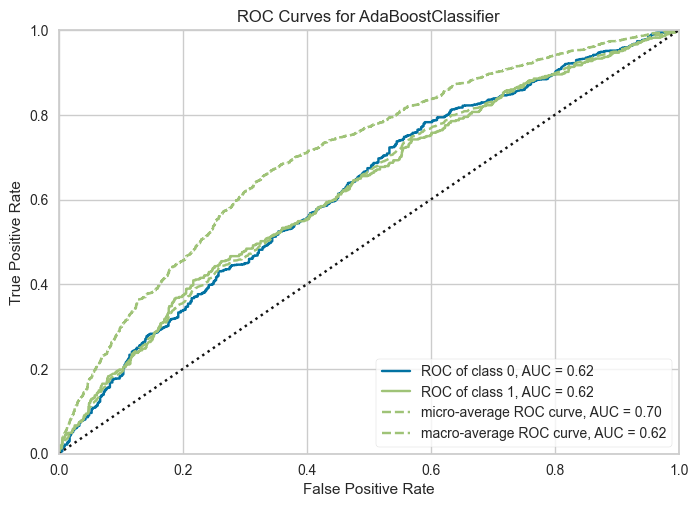

In [41]:
plot_model(best_model, plot="auc")

The AUC for each class was good: 0.85.

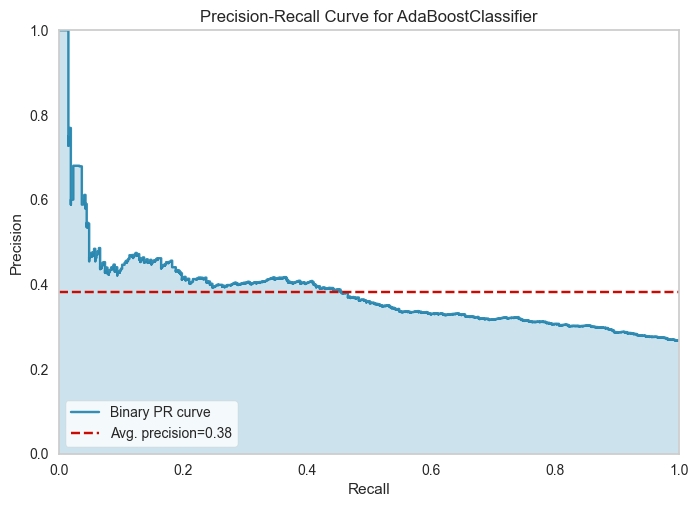

In [42]:
plot_model(best_model, plot="pr")

The PR curve got an average precision around 0.7, which is good.

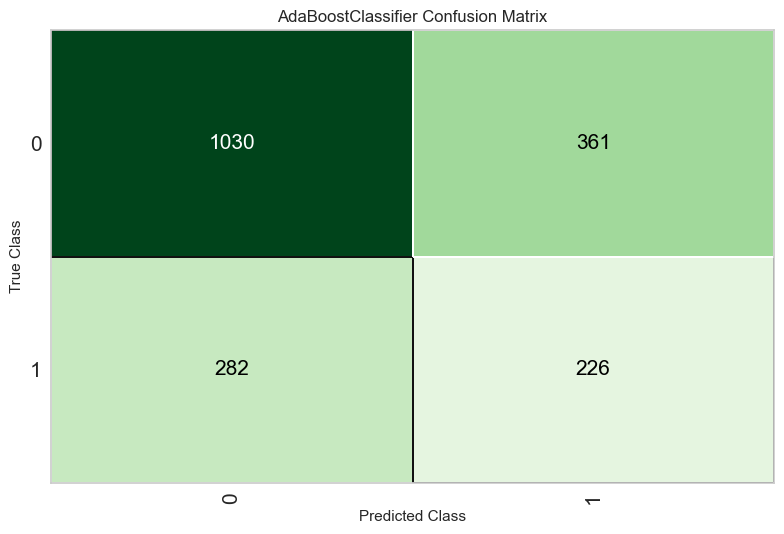

In [43]:
plot_model(best_model, plot="confusion_matrix")

The Confusion Matrix shows that the churned clients have been classified as not churn in 50% of the predictions

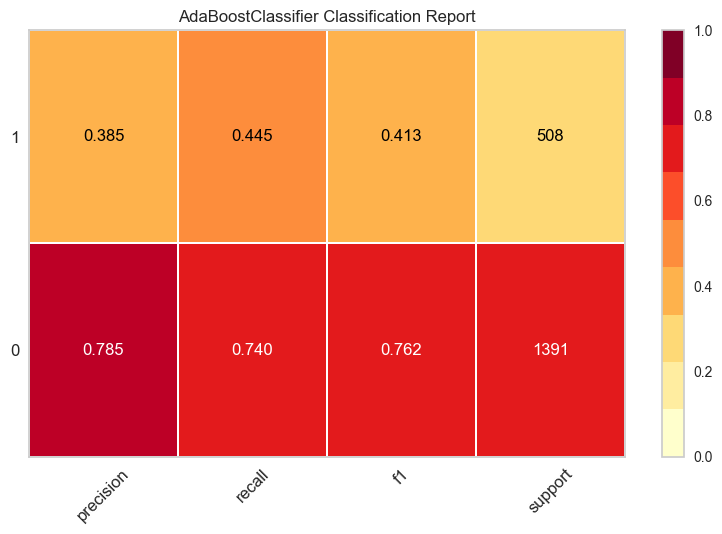

In [44]:
plot_model(best_model, plot="class_report")

The model has done a good work on the metrics for the class 0 (Not Churned) but got a Precision close to 0.5 for class 1 (Churned).

# 6. Prediction on Test Data

The test is made with the remaining 30% of data that PyCaret got on the setup, it's important to see that the model is not overfitting.

In [45]:
predict_model(best_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6614,0.6221,0.6614,0.6780,0.6687,0.1766,0.1775


As everything is right with the model, it's time to finalize it fitting all the data.

In [46]:
final_model = finalize_model(best_model)

# 7. Prediction on Unseen Data

The remaining 10% data is used to make predictions with unseen samples, what could include some outliers, it's how real world data works.<br>
Just Kappa Score is not showed, as the focus is the F1 Score, as Precision and Recall are importants to get False Positives and False Negatives.<br>
It's not necessary to make any transformation on the data, PyCaret do this.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7568,0.8186,0.7568,0.8032,0.7697,0.4385,0.4558


 Accuracy  AUC  Recall  Precision  F1 Score
      1.0  1.0     1.0        1.0       1.0


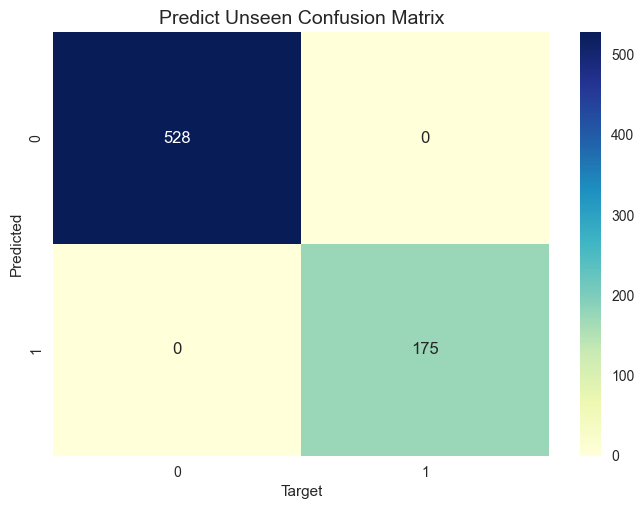

In [48]:
predict_unseen = predict_model(final_model, data=data_unseen)
score_unseen = test_score_report(data_unseen, predict_unseen)
print(score_unseen.to_string(index=False))
conf_mat(data_unseen, predict_unseen)

And the Unseen Data predicts as the trained model! The model was sucessful built! 

# 8. Save Experiment and Model

PyCaret allows to save all the pipeline experiment and the model to deploy.<br>
It's recommended to save with date of the experiments.

In [50]:
PATH = r"c:\Lab_assignment(EAI)"
model_dir = os.path.join(PATH, "models")
os.makedirs(model_dir, exist_ok=True)


model_path = os.path.join(model_dir, f"modelCCP_{date.today().strftime('%m-%d-%Y')}")
save_model(final_model, model_path)


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['SeniorCitizen'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strate...
                                                                      criterion='entropy',
                                                                      max_dept

# 9. Conclusion

From the results and explanations presented here, some conclusion can be draw:
* The type of contract has a strict relationship with churned clients, Month-to-month contracts with high amount of charges could lead a client to leave the service.
* The Best Model is an AdaBoostClassifier with Logistic Regression as Base Estimator.
* For the predictions made by the model and based on the precision and recall scores, as F1 Score try to show a balance between these two metrics, the precision was near 50%, what means that the model predict correctly 50% of classified clients as churned, on other hand, the recall was good, where around 83% of the actually churned clients was predict correctly.
* The metrics must be used in favor of the business interests: Is needed a more correct prediction of the churned clients or get a more amount of these clients on the predictions?

From the tools and enviroment used:
* PyCaret is incredible, it speed up the model build a lot and the pre-processing is very useful, beyond of the functions to save and deploy the model.